<center><img src="img/food.png" width="30%"/></center>

# L'endometriosi e il cibo

L'endometriosi è una malattia cronica che debilita fortemente le persone che ne soffrono, sia fisicamente che psicologicamente. Biologicamente, si tratta di tessuto uterino che cresce al di fuori dell'utero, molto spesso vicino all'intestino: al momento, non vi è cura, ma solo delle terapie volte a limitare i sintomi di tale patologia. 

Tra le varie terapie, è altamente consigliata una dieta particolare che esclude cibi considerati infiammatori e suggerisce l'assunzione di cibi che invece tendono a sfiammare e a rilassare l'intestino. Questa dieta è stata studiata da un punto di vista prettamente chimico-biologico, ma coloro che soffrono di endometriosi hanno sempre fatto notare come per loro queste linee guida non solo non funzionassero, ma addirittura le facessero star peggio.

Allora mi sono chiesta se ci fosse un modo di poter creare un sistema che, preso in input un vettore di valutazioni su alcuni cibi, fosse in grado di restituire in output una serie di cibi, diversi dall'input, con un coefficiente di sicurezza/pericolo personalizzato sull'esperienza del singolo, piuttosto che delle linee guida generiche.

# Preparazione librerie e caricamento dati

Nel corso del notebook saranno caricate le varie funzioni necessarie sul momento, ma intanto carichiamo le librerie che saranno utlizzate in tutto il progetto: oltre alle librerie già viste a lezione, è caricata **surprise**, una libreria specializzata in sistemi di raccomandazione i cui algoritmi restituiscono direttamente la predizione del cibo voluto rispetto all'utente analizzato.

Link: https://surpriselib.com/

In [24]:
# carichiamo le librerie principali

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random as rd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import surprise

I dati provengono da un sondaggio effettuato tramite Facebook e passaparola mediante l'utilizzo di un form Google da me creato (https://forms.gle/T7Gba9441dZayLoe9). A coloro che hanno accettato di partecipare sono state chieste le seguenti informazioni:
* Età
* Da quanto tempo soffrano di endometriosi
* Di dare un voto da 1 a 5 ai diciannove cibi proposti, dove 1 indica che il cibo in analisi non gli fa male e 5 invece indica che gli fa male

Specifico che nel raccogliere tale valutazioni ho voluto includere anche un'opzione "Non lo mangio per altri motivi" così da tener conto di diete particolari, motivi religiosi o allergie e stare sicura di non considerare questi dati, così da evitare di falsare i risultati.

Una volta chiuso il sondaggio, i dati sono stati esportati in cvs e ora li trasformeremo per praticità in un dataframe Pandas.

In [25]:
df = pd.read_csv('Dati/raw_data.csv')

# rimuoviamo la colonna "informazioni cronologiche"
# si tratta della data e dell'orario in cui è stato 
# compilato il sondaggio, quindi non ci interessa
df = df.drop(['Informazioni cronologiche'], axis = 1)

Per praticità, codifichiamo i dati "Non lo mangio per altri motivi" con 0.

In [26]:
df[df == "Non lo mangio per altri motivi"] = 0

Inoltre, per fare una prima analisi dei dati, ci è utile avere codificati come numeri anche la colonna "Da quanto soffre di endometriosi".

In [27]:
# i valori sono solo simbolici
# per le fasce di periodo si è preso 
# il punto medio dell'intervallo
df[df == "Più di 10 anni"] = 10
df[df == "5-10 anni"] = 7
df[df == "1-5 anni"] = 3
df[df == "Meno di 1 anno"] = 1

# in una casella "età" sono presenti informazioni
# non pertinenti a questo campo
# modifichiamolo con il solo numero
df[df == "Valentina 51 anni"] = 51

# convertiamo il tipo del dataframe
# per poter usare senza problemi molte funzioni
df = df.astype(np.int64)

df

,Età,Da quanto soffre di endometriosi?,Bibite gassate,Caffeina,Cannella,Carne bianca,Carne rossa,Cibi fritti,Curcuma,Frutta secca,...,Latticini,Legumi,Melanzane,Molluschi,Patate,Riso,Salmone,Salumi,Soia,Uova
0,52,7,2,5,0,1,5,2,0,4,...,5,4,4,5,4,4,1,2,5,2
1,60,10,2,1,1,1,2,2,1,2,...,1,2,3,1,1,2,1,2,1,2
2,52,10,4,3,1,1,2,2,2,2,...,2,2,2,2,2,1,1,2,2,1
3,40,10,4,1,1,1,1,4,1,1,...,3,3,3,1,3,1,1,2,3,1
4,45,10,1,0,1,1,2,1,1,1,...,4,3,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,44,10,3,2,1,3,4,4,1,1,...,4,4,1,1,2,3,1,4,2,3
488,44,7,3,2,2,2,3,2,1,2,...,3,3,2,1,1,1,1,3,3,2
489,27,3,3,1,1,1,2,2,1,1,...,3,2,1,1,2,2,1,4,0,1
490,31,3,4,4,2,2,2,4,2,3,...,4,4,4,0,4,3,2,4,4,0


Sempre per comodità, salviamo in due variabili predefinite il numero di esempi a nostra disposizione (*n_rows*) e di variabili (*n_cols*).

In [28]:
n_rows = df.shape[0]
n_cols = df.shape[1]

# Analisi distribuzione dei dati

Sappiamo che per l'endometriosi esiste già una dieta consigliata, quindi ci si potrebbe chiedere se creare un sistema di raccomandazione sia davvero così necessario. Per rispondere a tale domanda analizziamo i dati raccolti:

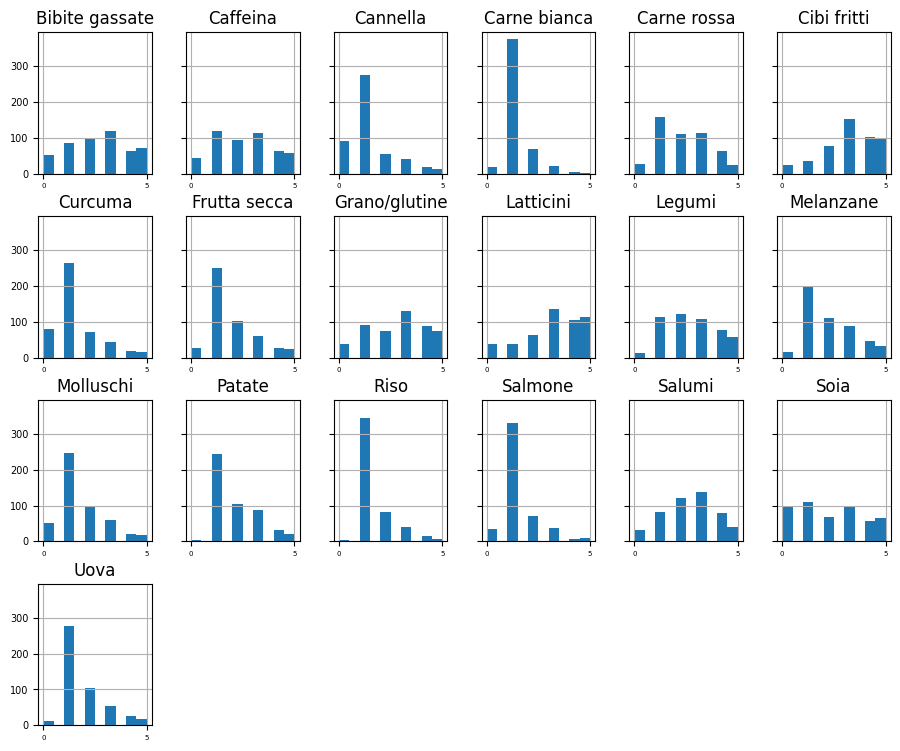

In [29]:
columns = df.columns.to_list()

# in questo caso ci interessano solo i cibi
columns.remove("Età")
columns.remove("Da quanto soffre di endometriosi?")

# plottiamo gli istogrammi dei vari cibi
df.hist(column = columns, figsize=(11,9), layout=(4, 6), 
        sharey=True, ylabelsize = 7, xlabelsize = 5);

I cibi su cui è stato fatto il sondaggio sono i cibi che la dieta consiglia/vieta di mangiare, ma, ad eccezione di alcuni cibi oggettivamente sicuri (come la carne bianca, con molti 1 e quasi nessun 5), possiamo notare come gli altri cibi siano più o meno equamente distribuiti: quindi sì, un sistema di raccomandazione che sia personalizzato sull'esperienza dell'utente potrebbe essere di aiuto nel creare una dieta specifica che aiuti chi soffra di endometriosi.

Procediamo dunque con un'analisi preliminare su come i dati si relazionino tra loro andando a verificare se esista una qualche correlazione tra i dati. In particolare, ci interessa sapere se in qualche modo l'età o il periodo passato dalla diagnosi influiscano sulle valutazioni date:

In [30]:
# done è la lista che evita di calcolare due volte 
# il coefficiente di correlazione, che sappiamo 
# essere una quantità simmetrica
done = []
corr =[]

for col in df.columns:
    for col2 in df.columns:
        if col != col2 and (col2 not in done): 

            ph_corr = df[col].corr(df[col2])

            # dato che ci sono molti coefficienti
            # stampiamo solo quelli che indicano una 
            # correlazione importante, ossia solo se 
            # il coefficiente è maggiore di 0.50 
            # o se è minore di -0.50
            if ph_corr > 0.49 or ph_corr < -0.49:
                print("Possibile correlazione tra", col, "-", 
                      col2, ":", ph_corr)
            corr.append(ph_corr)
    done.append(col)

# calcoliamo la media delle correlazioni
mean_corr = 0
for ph in corr:
    mean_corr += np.abs(ph)
print("La correlazione media è", mean_corr/len(corr))

#print(corr)

Possibile correlazione tra Cannella - Curcuma : 0.5011589100785873
La correlazione media è 0.16838459564683536


Dalla media dei coefficienti risulta dunque che le colonne non siano poi così tanto correlate tra di loro (in generale, facendole stampare tutte si può vedere infatti che molti coefficienti sono quasi nulli) e, in particolare, ne possiamo dedurre che la reazione a determinati cibi non dipende nè dall'età, nè da quanto si soffre di endometriosi: possiamo dunque eliminare queste colonne e concentrare il nostro sistema di raccomandazione sulle sole votazioni.

Evito di riportare la scatter_matrix date le dimensioni che avrebbe questa matrice.

In [31]:
df = df.drop(["Da quanto soffre di endometriosi?", "Età"], axis = 1)
n_cols = len(df.columns)

# Formattazione dati per il pacchetto ````Surprise````

Prima di procedere con la creazione dei sistemi di raccomandazione, dobbiamo modificare il formato dei dati così da poter utilizzare la libreria `Surprise`: infatti, tale pacchetto, si aspetta in input una classe specifica chiamata *Dataset*, che può essere ottenuta utlizzando i dataset preesistenti o caricando i propri dati da un dataframe di dimensioni *N*x*3*, dove *N* è l'intero dato da *n_cols* per *n_rows* e le righe abbiano la forma 
$$
["\text{user-id}"]   [\text{"item-id"}] ["\text{rating}"]
$$

Praticamente, `Surprise` richiede che il dataframe abbia una riga per ogni valutazione di ogni oggetto: nel nostro caso dunque avremmo *9348* righe e *3* colonne, chiamate rispettivamente "users", "food e "ratings". In realtà avremo leggermente meno righe, a causa dei valori nulli che non vogliamo considerare.

Ora possiamo creare un dataframe ausiliario che escluda le celle con valutazione nulla e che abbia il formato desiderato da `Surprise`.

In [32]:
users = []
food = []
ratings = []

for i in range(n_rows):
    for j in range(n_cols):
        if (df[df.columns[j]][i] != 0):
            ratings.append(df[df.columns[j]][i])
            users.append(i)
            food.append(j)

df_s = pd.DataFrame([users,food,ratings], 
                    index = ['users', 'food', 'ratings']).transpose()
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8644 entries, 0 to 8643
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   users    8644 non-null   int64
 1   food     8644 non-null   int64
 2   ratings  8644 non-null   int64
dtypes: int64(3)
memory usage: 202.7 KB


Per aiutare l'apprendimento, modifichiamo leggermente i dati per renderli più diversi tra loro. Dopo alcune prove, uno dei valori migliori per tale operazione è risultato essere 5, così da allontanare i valori ma non troppo.

In [33]:
df_s = df_s * 5

Definiamo anche una funzione che, dato in input un numero, restituisce l'intero multiplo di cinque più vicino (ci servirà più tardi per valutare la performance dei modelli).

In [34]:
def round_to_five(n):

    # le predizioni sono float, ma il cast generico 
    # ci farebbe perdere informazioni importanti
    n = round(n)    

    # arrotondiamo al multiplo di 5 più vicino
    r = n%5
    if r == 1 or r == 2:
        m = n - r
    elif r == 3 or r == 4:
        m = n + (5 - r)
    elif r == 0:
        m = n 

    return(m)

Per trasformare il dataframe in un oggetto *Dataset* useremo il *Reader*, una classe di `Surprise` che permette di "leggere" i dati e modificarli in un oggetto dataset: i parametri importanti da assegnare sono l'ordine delle colonne del dataframe da leggere e l'intervallo delle valutazioni.

In [35]:
# importiamo i pacchetti specifici
from surprise import Dataset, Reader
from surprise.model_selection.split import train_test_split

reader = Reader(line_format='user item rating', rating_scale=[5,25])
data = surprise.Dataset.load_from_df(df_s, reader)

# creiamo trainset e testset
trainset, testset = train_test_split(data, test_size=0.2, 
                                     random_state=42, shuffle=True)

# Sistema di raccomandazione 1: clustering KNN

Iniziamo importando i pacchetti e le funzioni specifiche che ci serviranno per questa sezione.

In [36]:
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNWithZScore
from surprise import accuracy

Prima di eseguire l'algoritmo per le predizioni, dato che si tratta di un modello basato sul clustering KNN, cerchiamo il massimo numero di nodi nel cluster (parametro *k*) che ottimizzi il nostro risultato. A tale scopo sfruttiamo la funzione **GridSearchCV** del pacchetto `Surprise`, la quale, preso in input l'algoritmo e una griglia di valori possibili per gli iper-parametri, applica la cross validation per ognuno di questi valori e restituisce la combinazione migliore in termini della funzione costo scelta.

In questo caso, i possibili valori di *k* sono ridotti solo a quattro dopo aver effettuato precedentemente delle ricerche a griglia con dimensioni più elevate.



In [37]:
param_grid = {
  'k': [111, 132, 154, 189],
}

gs = GridSearchCV(KNNWithZScore, param_grid, measures=['fcp', 'mae'], cv=7)
gs.fit(data)

# le celle sono state separate per evidenziare 
# gli output delle cella successiva

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [38]:
# la variabile gs, per definizione, contiene 
# vari dizionari con i risultati della ricerca
# indicizzati con il nome della misura
print("I migliori punteggi, mediati sulla cross validation, sono stati:")
print("fcp =", round(gs.best_score['fcp'],5), 
      "\nmae =", round(gs.best_score['mae'],5))
print("con il parametro k =", gs.best_params['fcp']["k"])

# salviamo k
k = gs.best_params['fcp']["k"]

I migliori punteggi, mediati sulla cross validation, sono stati:
fcp = 0.63378 
mae = 3.85403
con il parametro k = 111


Nella grid search sono state utlizzate due metriche diverse, il **mae** e la **fcp**.

Il **mae**, ossia il Mean Absolute Error su m esempi, è definito come
$$
mae = \sum_{k=1}^m |\hat{r}_k - r_k|
$$
La **fcp** invece è la Fraction of Concordant Pairs. Questa funzione costo viene definita nell'articolo *"Collaborative Filtering on Ordinal User Feedback"* di Koren et Sill come
$$
    fcp = \frac{n_c}{n_c + n_d}
$$ 
dove
$$
n_c = \sum_{u} n_{c}^{u}
$$
e analogamente n_d per le coppie discordanti.
Per coppie concordanti si intendono le coppie di predizioni che rispettano *l'ordine* delle vere valutazioni e vengono contate per utente:
$$
n_{u}^c = |\{ (i,j): \hat{r}_{ui}< \hat{r}_{uj} \text{ and } r_{ui} < r_{uj}\}|
$$
Questa seconda misura è molto usata quando è più importante la classifica e la relazione tra le valutazioni del valore in sè che queste hanno, proprio come in questo caso.

**Idea**

L'idea di questo sistema di raccomandazione è di valutare i voti mancanti in base alle valutazioni degli utenti più *simili* all'utente analizzato. Questa similitudine sarà calcolata tramite una specifica distanza scelta tra **msd**, **cosine** e **pearson**.

La distanza **msd** è basata sulla Mean Squared Difference, definita come
$$
    msd(u,v) = \frac{1}{|I_{uv}|} \sum_{i \in I_{uv}} (r_{ui} - r_{vi})^2
$$
ossia, presi due utenti $u,v$, la distanza è calcolata sugli oggetti $i$ in in comune tra i due come somma di quadrati e poi mediata sul numero di questi oggetti comuni. Nel nostro caso, dunque, per ogni coppia $(u,v)$ saranno considerate solo i cibi per cui entrambi gli utenti abbiano dato una valutazione. La somiglianza tra gli utenti sarà dunque calcolata come
$$
    \text{sim}_\text{msd} (u,v) = \frac{1}{1+ \text{msd}(u,v)}
$$
dove il +1 al denominatore viene messo per evitare di dividere per zero.

La somiglianza **cosine** è definita come
$$
    \text{sim}_\text{cosine} (u,v) = \frac{\sum_{i \in I_{uv}} (r_{ui} \cdot r_{vi})}
    {\sqrt{\sum_{i \in I_{uv}} r_{ui}^2} \cdot \sqrt{\sum_{i \in I_{uv}} r_{vi}^2}}
$$
dove vengono nuovamente considerati solo i cibi in comune. Questa metrica però non è molto utile in questo caso dato che tiene più conto del numero di occorrenze di un determinato valore che del valore in sé.

Infine, ci sono due distanze basate sul coefficiente di correlazione di Pearson, ma in questo caso non ci sarebbero utili dato che i dati a nostra disposizione non presentano una grande correlazione tra di loro.

Utilizzeremo dunque la distanza **msd** applicata agli utenti.

Inoltre, dato che la dimensionalità dei dati è (relativamente) elevata, sarà implementato l'algoritmo KNN con la standardizzazione dei valori, così da tener conto di quanto i singoli voti influiscano sul determinare la posizione dell'utente nello spazio. Seguendo dunque questo procedimento, le predizioni saranno
$$
    \hat{r}_{ui} = \mu_u + \sigma_u \frac{\sum_{v\in N_{i}^{k}(u)} \text{sim}(u,v) \cdot (r_{vi} - \mu_v)/\sigma_v}{\sum_{v\in N_{i}^{k}(u)} \text{sim}(u,v)}
$$
dove **sim** è la somiglianza tra gli utenti $u$ e $v$, con $v$ preso tra i vicini del'utente $u$ rispetto al cibo $i$, e i voti $r_{vi}$ sono standardizzati attraverso la classica trasformazione
$$
\frac{r_{vi} - \mu_v}{\sigma_v}
$$
con $\mu_v$ e $\sigma_v$, rispettivamente, media e deviazione standard dei voti dell'utente $v$.

In [39]:
# definiamo l'algoritmo con l'iperparametro trovato prima,
# msd come distanza e specifichiamo che devono essere
# confrontati tra loro gli utenti, non i cibi
sim_options = {
    "name": "msd",
    "user_based": True, 
}
alg = KNNWithZScore(k = k, verbose=False, sim_options = sim_options)

# eseguiamo il fit sul trainset
alg.fit(trainset)

# prediamo le valutazioni del testset
predictions = alg.test(testset)

# stampiamo l'accuratezza con le metriche fcp e mae
print("L'accuratezza sul testset è:")
accuracy.fcp(predictions);
accuracy.mae(predictions);

L'accuratezza sul testset è:
FCP:  0.6500
MAE:  3.9221


A questo punto abbiamo a disposizione una lista di *prediction*. Questa classe identifica una tupla costruita con l'apposito scopo di condensare in una sola variabile tutte le informazioni utili in una predizione, ossia l'identificativo dell'user, l'identificativo del cibo, il vero valore (se noto), il valore stimato e dei dettagli sulla riuscita della predizione. Possiamo dunque valutare gli errori di stima in base alle nostre esigenze semplicemente estraendo le entrate **r_ui** e **est**, che identificano rispettivamente il vero valore per il cibo *i* dall'utente *u* e la stima del nostro algoritmo.

É importante focalizzare quale sia lo scopo di questo sistema di raccomandazione: l'idea di questo progetto è creare un sistema che possa essere di aiuto alle persone e non ottenere una predizione esatta di ciò che potrebbero pensare gli utenti di un determinato cibo. Per questo motivo, ho deciso di non considerare come errori le stime errate di una sola classe: infatti, non mi interessa che un cibo sia valutato 1 invece di 2 (o viceversa) perché il relativo cibo sarebbe comunque reputato sicuro dal sistema, ma mi interessa che l'algoritmo non reputi sicuri dei cibi che invece sarebbero dannosi (del tipo "vero = 5, predetto = 1"). 

Dato che la stessa funzione sarà utilizzata anche nel secondo sistema di raccomandazione, definiamo una funzione ausiliaria per valutare le predizioni.

In [40]:
def error_count(predictions):

    pred = []
    true = []
    errori_gravi = 0

    for item in predictions:

        # estraiamo il rating predetto e quello vero
        ph_est = item.est
        r_ui = item.r_ui

        # arrotondiamo al multiplo di 5 più vicino
        est = round_to_five(ph_est)

        # salviamo i voti predetti e i voti veri
        # nelle apposite liste, così da poter disegnare
        # la matrice di confusione
        pred.append(est)
        true.append(r_ui)

        # vediamo se la predizione è sbagliata 
        # di più di un punto
        if np.abs(est - r_ui) >= 10 : errori_gravi += 1

    frac = round(errori_gravi/len(predictions)*100, 2)

    #print(errori_gravi, "su", len(predictions))
    print("La percentuale di errori gravi è:", frac)

    return(pred, true)

La percentuale di errori gravi è: 14.34


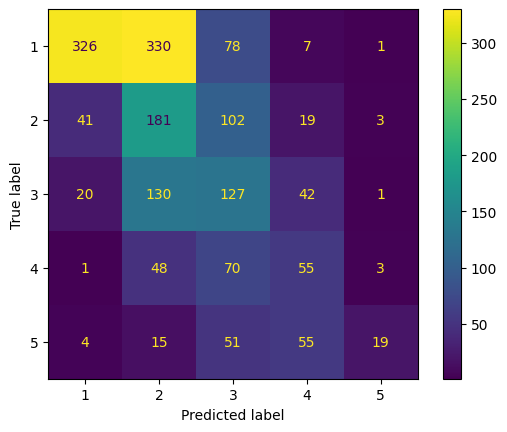

In [41]:
# vediamo gli errori gravi
pred, true = error_count(predictions)

# creiamo la matrice di confusione
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =[1,2,3,4,5])
disp.plot()
plt.show()

# Sistema di raccomandazione 2: SVD

Dopo una prima implementazione di un metodo intuitivo, ho pensato di usare un altro metodo per calcolare le predizioni, ossia tramite la **Singular Vector Decomposition**, così come fu presentata al Netflix Prize. Il motivo di tale scelta è sia per confrontare due algoritmi con basi molto diverse, sia per ottenere una riduzione nel tempo di esecuzione.

Introduciamo dunque il pacchetto necessario per la **SVD**.

In [42]:
from surprise import SVD

L'algoritmo SVD ha molti iper-parametri da dover considerare, ma noi focalizzeremo la nostra attenzione sul numero di fattori, sul numero di epochs e sui termini di regoralizzazione. Specifico che per i primi due iper-parametri non sono stati posti dei valori elevati dato il numero ridotto di esempi.

Le metriche sono le stesse definite nel caso KNN.

In [43]:
# definiamo la griglia
param_grid = {
  'n_factors': [20, 30, 50],
  'n_epochs': [5, 7, 9],
  "lr_all" : [0.005, 0.05, 0.5],
  "reg_all": [0.002, 0.02, 0.2]
}
 
# effettuiamo la ricerca a griglia
gs = GridSearchCV(SVD, param_grid, measures=['fcp', 'mae'], cv=7)
gs.fit(data)

# salviamo i parametri in variabili apposite
n_factors = gs.best_params['fcp']["n_factors"]
n_epochs = gs.best_params['fcp']["n_epochs"]
reg_all = gs.best_params['fcp']["reg_all"]
lr_all = gs.best_params['fcp']["lr_all"]

# stampa
print("I migliori punteggi, mediati sulla cross validation, sono stati:")
print("fcp =", round(gs.best_score['fcp'],5), 
      "\nmae =", round(gs.best_score['mae'],5))
print("con i parametri", gs.best_params['fcp'])

I migliori punteggi, mediati sulla cross validation, sono stati:
fcp = 0.6351 
mae = 3.74895
con i parametri {'n_factors': 50, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.002}


I sistemi di raccomandazione che si basano sulla fattorizzazione di matrici, generalmente, seguono il seguente schema: data una matrice $\mathbf{R}$ del tipo $users$ x $items$ contenente le valutazioni degli utenti per i singoli oggetti, si cerca di approssimare le celle conosciute come prodotto di una matrice $\mathbf{Q}$, che analizza i voti rispetto agli oggetti, e una matrice $\mathbf{P}$, che invece li analizza rispetto agli utenti. 

<center><img src="img/matrix_fact.jpg" width="75%" /></center>

Di solito, la matrice $\mathbf{R}$ avrà dei valori mancanti e quindi è utile applicare un algoritmo come la SVD che riempa questi spazi vuoti con dei valori predetti come $\hat{r}_{ui} = q_{i}^T p_u$.
In particolare, seguendo la notazione SVD, $\mathbf{R}$ è la matrice di input, $\mathbf{Q} = \mathbf{U}$ e $\mathbf{P}^T = \Sigma \mathbf{V}^T$.

Per poter stimare i valori mancanti, l'algoritmo cerca di minimizzare l'errore quadratico regolarizzato
$$
    \sum_{r_{ui} \in R_{train}} (r_{ui} - \hat{r}_{ui})^2 + \lambda (||q_i||^2 + ||p_i||^2)
$$
tramite l'algoritmo di discesa stocastica del gradiente:
$$
    p_u \leftarrow p_u + \eta(\epsilon_{ui}\cdot q_i - \lambda p_u )
    \\
    q_i \leftarrow q_i + \eta(\epsilon_{ui}\cdot p_u - \lambda q_i )
$$
dove $\epsilon_{ui} = r_{ui} - \hat{r}_{ui}$. Questi aggiornamenti sono eseguiti per ogni esempio nel training set, che viene analizzato per un numero fissato di epochs. Per quanto riguarda l'inizializzazione dei parametri, le matrici $\mathbf{Q}$ e $\mathbf{P}$ vengono inizializzate secondo una distribuzione normale di parametri $\mu = 0$ e $\sigma = 0.1$.

In [44]:
# definizione metodo
alg = SVD(n_factors = n_factors, n_epochs = n_epochs, 
          reg_all = reg_all , lr_all = lr_all, verbose = False)

# fit sul training set
alg.fit(trainset)

# prediamo le valutazioni del testset
predictions = alg.test(testset)

# stampiamo l'accuratezza con le metriche fcp e mae
print("L'accuratezza sul testset è:")
accuracy.fcp(predictions);
accuracy.mae(predictions);

L'accuratezza sul testset è:
FCP:  0.6419
MAE:  3.9409


Analogamente al caso KNN, analizziamo i risultati ottenuti.

La percentuale di errori gravi è: 14.63


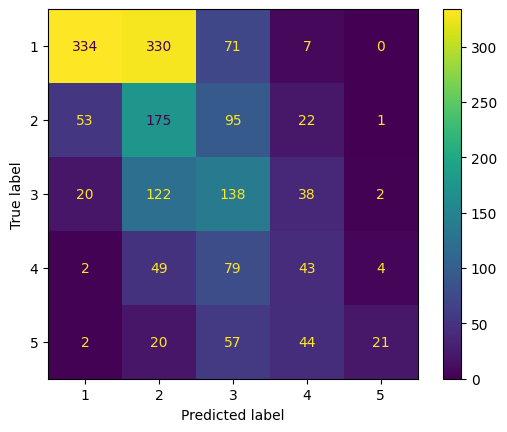

In [45]:
# vediamo gli errori gravi
pred, true = error_count(predictions)

# creiamo la matrice di confusione
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =[1,2,3,4,5])
disp.plot()
plt.show()

# Conclusioni

I metodi presentati, nonostante due impostazioni molto diverse, portano a risultati molto simili tra di loro, con l'unica differenza sostanziale nel tempo di esecuzione dei due algoritmi e della relativa grid search.

I risultati ottenuti sono ben lontani dall'essere perfetti, ma fanno ben sperare: se con così pochi dati e così codificati riusciamo ad ottenere già dei numeri di questo calibro, migliorando la qualità/quantità dei dati o anche provando degli algoritmi più sofisticati (come ad esempio l'**OrdRec** proposto da Koren et Sill nell'articolo *"Collaborative Filtering on Ordinal User Feedback"*) potremmo sicuramente riuscire a implementare un sistema molto più sicuro e più utile.